# Biological pathway activity inference

Using DecoupleR.

# 0. Loading the libraries

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from pyorthomap import findOrthologsMmHs
import decoupler as dc

import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [2]:
# Set up constants
save_folder = "figures/"
objects_folder = "saved_objects/"
sc.settings.figdir = './'+save_folder

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

# 1. Reading in the data

In [3]:
# Load the pre-processed data

with open('saved_objects/adata_annotated.pkl', 'rb') as inp:
    adata = pickle.load(inp)

In [4]:
adata.obs['log_il10'] = adata.X[:, adata.var['gene_name'] == 'Il10']

In [5]:
# Convert to human gene names

def replace(x):
    if len(x.tolist()) == 1:
        if x.tolist()[0] != x.tolist()[0]:
            return "NA"
        else:
            return(x.tolist()[0])
    else:
        return "NA"

translated = findOrthologsMmHs(from_filters = 'external_gene_name',
                               from_values = adata.var.index.tolist()).map()
adata.var['human_name'] = [replace(translated[translated.external_gene_name == e]["hgnc_symbol"]) for e in adata.var['gene_name']]

adata = adata[:,~(adata.var.human_name == "NA")]
adata.var = adata.var[~(adata.var.human_name == "NA")]
adata.var = adata.var.set_index("human_name")

  0%|          | 0/49 [00:00<?, ?it/s]

In [6]:
adata0 = adata.copy()
adata1 = adata[adata.obs['cond'] == 'N6'].copy()
adata2 = adata[adata.obs['tp'] == '48h'].copy()
adata3 = adata[adata.obs['sample2'] == 'N6-48h'].copy()

/opt/python/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
for data in [adata1, adata2, adata3]:
    # Calculate the visualizations
    sc.pp.pca(data, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(data)

    sc.tl.umap(data)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50


2022-06-24 11:53:47.215891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib:
2022-06-24 11:53:47.215976: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:45)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    fini

In [8]:
names = ["all", "N6", "48h", "N6-48h"]

# 2. DecoupleR

In [9]:
def run_decoupler(data, net, groupkey, name):
    
    mat = pd.DataFrame(data.X, columns = data.var_names, index = data.obs_names)

    test = dc.decouple(mat=mat, net=net, methods = ['mlm', 'ulm', 'ora', 'aucell'],verbose=True)

    data.obsm['test_estimate'], data.obsm['test_pvals'] = test['consensus_estimate'], test['consensus_pvals']
    acts = dc.get_acts(data, obsm_key='test_estimate')
    mean_acts = dc.summarize_acts(acts, groupby=groupkey, min_std=0.1) #0.3
    diffs = abs(mean_acts.diff().iloc[1,:])
    mean_acts = mean_acts.filter(diffs.nlargest(30).index.tolist())
    rats = mean_acts.pct_change().iloc[1,:]

    l = diffs.nlargest(min(len(diffs//2), 3)).index.tolist() + rats.nsmallest(min(len(diffs//2), 3)).index.tolist()
    sc.pl.umap(acts, color=l+['log_il10', groupkey], cmap='coolwarm', vcenter=0, size = 40, ncols=4, show=False, save="_"+name+".pdf")
    
    mean_acts = mean_acts.filter(rats.nlargest(min(len(rats//2), 15)).index.tolist() + rats.nsmallest(min(len(rats//2), 15)).index.tolist())
    plot = sb.clustermap(mean_acts, center=0, xticklabels=mean_acts.columns, cmap='coolwarm')
    plot.fig.savefig(save_folder+"heatmap_"+name+".pdf")
    plt.close()

In [10]:
def run_upr(data, net, groupkey, name):
    
    mat = pd.DataFrame(data.X, columns = data.var_names, index = data.obs_names)
    test = dc.decouple(mat=mat, net=net, methods = ['mlm', 'ulm', 'ora', 'aucell'],verbose=True)

    data.obsm['test_estimate'], data.obsm['test_pvals'] = test['consensus_estimate'], test['consensus_pvals']
    acts = dc.get_acts(data, obsm_key='test_estimate')

    sc.pl.umap(acts, color=['HALLMARK_UNFOLDED_PROTEIN_RESPONSE', groupkey], cmap='coolwarm', vcenter=0, size = 40, ncols=4, show=False, save="_upr_"+name+".pdf")

    marker = 'Il10'
    sc.tl.embedding_density(data, basis='umap', groupby=marker+'_positive')
    sc.pl.embedding_density(data, basis='umap', key='umap_density_'+marker+'_positive', group=marker+'+', save="_upr_"+name+".pdf")

# 3. Functional enrichment of 'Hallmark' gene sets

In [11]:
net = dc.get_resource('MSigDB')
# Filter by hallmark
net = net[net['collection']=='hallmark']

# Remove duplicated entries
net = net[~net.duplicated(['geneset', 'genesymbol'])]
net = dc.rename_net(net, source='geneset', target='genesymbol', weight=None)
net

label,source,target,weight
11,HALLMARK_TNFA_SIGNALING_VIA_NFKB,MSC,1.0
149,HALLMARK_TNFA_SIGNALING_VIA_NFKB,ICOSLG,1.0
223,HALLMARK_INFLAMMATORY_RESPONSE,ICOSLG,1.0
270,HALLMARK_ALLOGRAFT_REJECTION,ICOSLG,1.0
398,HALLMARK_HYPOXIA,FOSL2,1.0
...,...,...,...
878342,HALLMARK_PANCREAS_BETA_CELLS,FOXO1,1.0
878418,HALLMARK_PANCREAS_BETA_CELLS,GCG,1.0
878512,HALLMARK_PANCREAS_BETA_CELLS,PDX1,1.0
878605,HALLMARK_PANCREAS_BETA_CELLS,INS,1.0


In [12]:
analysis_name = "HM_"
run_decoupler(adata0, net, 'sample2', analysis_name+names[0])
run_decoupler(adata1, net, 'tp', analysis_name+names[1])
run_decoupler(adata2, net, 'cond', analysis_name+names[2])
run_decoupler(adata3, net, 'Il10_positive', analysis_name+names[3])

Running mlm on mat with 37425 samples and 10561 targets for 50 sources.


100%|██████████| 4/4 [00:45<00:00, 11.48s/it]


Running ulm on mat with 37425 samples and 10561 targets for 50 sources.
Running ora on mat with 37425 samples and 10561 targets for 50 sources.


100%|██████████| 37425/37425 [03:05<00:00, 202.09it/s]
/opt/python/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


Running aucell on mat with 37425 samples and 10561 targets for 50 sources.
Running mlm on mat with 19361 samples and 10561 targets for 50 sources.


100%|██████████| 2/2 [00:23<00:00, 11.68s/it]


Running ulm on mat with 19361 samples and 10561 targets for 50 sources.
Running ora on mat with 19361 samples and 10561 targets for 50 sources.


100%|██████████| 19361/19361 [01:19<00:00, 243.39it/s]
/opt/python/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


Running aucell on mat with 19361 samples and 10561 targets for 50 sources.
Running mlm on mat with 7418 samples and 10561 targets for 50 sources.


100%|██████████| 1/1 [00:07<00:00,  7.86s/it]


Running ulm on mat with 7418 samples and 10561 targets for 50 sources.
Running ora on mat with 7418 samples and 10561 targets for 50 sources.


100%|██████████| 7418/7418 [00:31<00:00, 236.02it/s]
/opt/python/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


Running aucell on mat with 7418 samples and 10561 targets for 50 sources.
Running mlm on mat with 6492 samples and 10561 targets for 50 sources.


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


Running ulm on mat with 6492 samples and 10561 targets for 50 sources.
Running ora on mat with 6492 samples and 10561 targets for 50 sources.


100%|██████████| 6492/6492 [00:28<00:00, 227.69it/s]
/opt/python/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


Running aucell on mat with 6492 samples and 10561 targets for 50 sources.


Running mlm on mat with 37425 samples and 10561 targets for 50 sources.


100%|██████████| 4/4 [00:41<00:00, 10.43s/it]


Running ulm on mat with 37425 samples and 10561 targets for 50 sources.
Running ora on mat with 37425 samples and 10561 targets for 50 sources.


100%|██████████| 37425/37425 [02:38<00:00, 235.88it/s]
/opt/python/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


Running aucell on mat with 37425 samples and 10561 targets for 50 sources.
computing density on 'umap'
--> added
    'umap_density_Il10_positive', densities (adata.obs)
    'umap_density_Il10_positive_params', parameter (adata.uns)


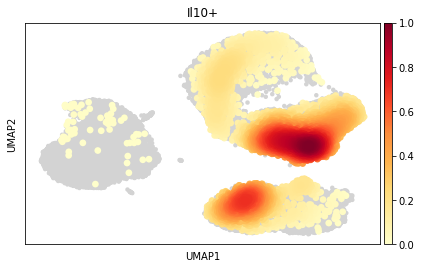

Running mlm on mat with 19361 samples and 10561 targets for 50 sources.


100%|██████████| 2/2 [00:25<00:00, 12.59s/it]


Running ulm on mat with 19361 samples and 10561 targets for 50 sources.
Running ora on mat with 19361 samples and 10561 targets for 50 sources.


100%|██████████| 19361/19361 [01:35<00:00, 203.73it/s]
/opt/python/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


Running aucell on mat with 19361 samples and 10561 targets for 50 sources.
computing density on 'umap'
--> added
    'umap_density_Il10_positive', densities (adata.obs)
    'umap_density_Il10_positive_params', parameter (adata.uns)


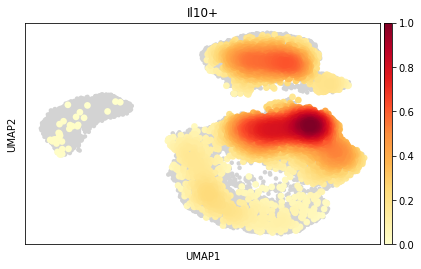

Running mlm on mat with 7418 samples and 10561 targets for 50 sources.


100%|██████████| 1/1 [00:09<00:00,  9.65s/it]


Running ulm on mat with 7418 samples and 10561 targets for 50 sources.
Running ora on mat with 7418 samples and 10561 targets for 50 sources.


100%|██████████| 7418/7418 [00:33<00:00, 219.15it/s]
/opt/python/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


Running aucell on mat with 7418 samples and 10561 targets for 50 sources.
computing density on 'umap'
--> added
    'umap_density_Il10_positive', densities (adata.obs)
    'umap_density_Il10_positive_params', parameter (adata.uns)


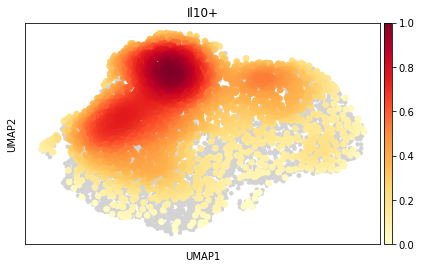

Running mlm on mat with 6492 samples and 10561 targets for 50 sources.


100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


Running ulm on mat with 6492 samples and 10561 targets for 50 sources.
Running ora on mat with 6492 samples and 10561 targets for 50 sources.


100%|██████████| 6492/6492 [00:31<00:00, 209.37it/s]
/opt/python/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


Running aucell on mat with 6492 samples and 10561 targets for 50 sources.
computing density on 'umap'
--> added
    'umap_density_Il10_positive', densities (adata.obs)
    'umap_density_Il10_positive_params', parameter (adata.uns)


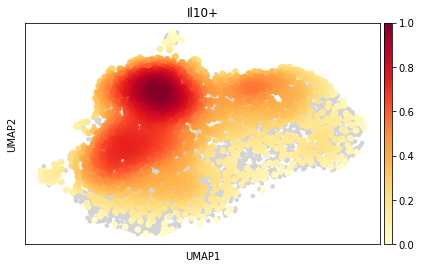

In [13]:
analysis_name = "HM_"
run_upr(adata0, net, 'sample2', analysis_name+names[0])
run_upr(adata1, net, 'tp', analysis_name+names[1])
run_upr(adata2, net, 'cond', analysis_name+names[2])
run_upr(adata3, net, 'Il10_positive', analysis_name+names[3])